# Generate Figures for Thesis

This notebook generates publication-quality figures from experiment results.

**Author:** Gheith Alrawahi  
**Institution:** Nankai University

---


In [21]:
# Cell 1: Imports and Setup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from config import RESULTS_DIR, FIGURES_DIR

# Style settings for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'lines.linewidth': 2,
})

# Color palette
COLORS = {
    'teacher': '#1f77b4',          # Blue
    'v1_baseline': '#9b59b6',      # Purple
    'v2_enhanced': '#2ecc71',      # Green (Best)
    'v3_dkd_beta8': '#e74c3c',     # Red (Failed)
    'v3_1_dkd_beta2': '#f39c12',   # Orange
    'v4_saturation': '#3498db',    # Blue
}

LABELS = {
    'teacher': 'Teacher (EfficientNetV2-L)',
    'v1_baseline': 'v1: Baseline',
    'v2_enhanced': 'v2: Standard KD',
    'v3_dkd_beta8': 'v3: DKD (β=8.0)',
    'v3_1_dkd_beta2': 'v3.1: DKD (β=2.0)',
    'v4_saturation': 'v4: Saturation Test',
}

print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")

Results directory: d:\Projects\MasterProject\code_v2\results
Figures directory: d:\Projects\MasterProject\code_v2\figures


In [22]:
# Cell 2: Load All Results (Updated for new structure)
def load_experiment_results(exp_dir: Path):
    """Load results for a single experiment from directory."""
    results = {}
    
    # Load final results
    final_path = exp_dir / 'final_results.json'
    if final_path.exists():
        with open(final_path, 'r') as f:
            results['final'] = json.load(f)
    
    # Load training history
    history_path = exp_dir / 'training_history.csv'
    if history_path.exists():
        results['history'] = pd.read_csv(history_path)
    
    # Load config (for student experiments)
    config_path = exp_dir / 'config.json'
    if config_path.exists():
        with open(config_path, 'r') as f:
            results['config'] = json.load(f)
    
    return results

def find_experiment_dir(base_id: str) -> Path:
    """Find experiment directory (handles timestamped directories)."""
    # First check exact match
    exact_path = RESULTS_DIR / base_id
    if exact_path.exists():
        return exact_path
    
    # Search for timestamped directories
    matching_dirs = list(RESULTS_DIR.glob(f"{base_id}_*"))
    if matching_dirs:
        # Return most recent
        return sorted(matching_dirs)[-1]
    
    return None

# Load Teacher results
experiments = {}
teacher_dir = RESULTS_DIR / 'teacher'
if teacher_dir.exists():
    experiments['teacher'] = load_experiment_results(teacher_dir)
    print(f"✓ Loaded: teacher")
else:
    print(f"✗ Not found: teacher")

# Load Student experiments
student_experiments = ['v1_baseline', 'v2_enhanced', 'v3_dkd_beta8', 'v3_1_dkd_beta2', 'v4_saturation']

for exp_id in student_experiments:
    exp_dir = find_experiment_dir(exp_id)
    if exp_dir and exp_dir.exists():
        experiments[exp_id] = load_experiment_results(exp_dir)
        print(f"✓ Loaded: {exp_id} ({exp_dir.name})")
    else:
        print(f"✗ Not found: {exp_id}")

print(f"\nLoaded {len(experiments)} experiments")

✓ Loaded: teacher
✓ Loaded: v1_baseline (v1_baseline_20251207_143632)
✓ Loaded: v2_enhanced (v2_enhanced_20251208_021230)
✓ Loaded: v3_dkd_beta8 (v3_dkd_beta8_20251208_104226)
✓ Loaded: v3_1_dkd_beta2 (v3_1_dkd_beta2_20251208_132844)
✓ Loaded: v4_saturation (v4_saturation_20251208_185409)

Loaded 6 experiments


In [23]:
# Cell 3: Create Summary Table (Updated for new structure)
def get_accuracy(exp_data, key='final_accuracy'):
    """Get accuracy from experiment data (handles both old and new structure)."""
    if 'final' not in exp_data:
        return 0
    
    results = exp_data['final'].get('results', {})
    
    # New structure uses 'final_accuracy'
    if key == 'final_accuracy':
        return results.get('final_accuracy', results.get('student_accuracy', 0))
    
    return results.get(key, 0)

def create_summary_table():
    """Create summary table of all experiments."""
    rows = []
    
    # Add Teacher
    if 'teacher' in experiments:
        data = experiments['teacher']
        results = data.get('final', {}).get('results', {})
        rows.append({
            'Experiment': 'Teacher',
            'Model': 'EfficientNetV2-L',
            'Method': '-',
            'Accuracy (%)': results.get('final_accuracy', 0),
            'Best Epoch': results.get('best_epoch', 0),
            'Total Epochs': results.get('total_epochs', 0),
            'Time (min)': results.get('training_time_minutes', 0)
        })
    
    # Add Students
    for exp_id in student_experiments:
        if exp_id not in experiments:
            continue
        
        data = experiments[exp_id]
        final = data.get('final', {})
        results = final.get('results', {})
        config = data.get('config', final.get('config', {}))
        
        # Get method from config
        distillation = config.get('distillation', {})
        method = distillation.get('method', 'N/A')
        if method == 'dkd':
            method = f"DKD (β={distillation.get('dkd_beta', 'N/A')})"
        elif method == 'standard_kd':
            method = 'Standard KD'
        
        rows.append({
            'Experiment': LABELS.get(exp_id, exp_id),
            'Model': 'EfficientNetV2-S',
            'Method': method,
            'Accuracy (%)': get_accuracy(data),
            'Best Epoch': results.get('best_epoch', 0),
            'Total Epochs': results.get('total_epochs', 0),
            'Time (min)': results.get('training_time_minutes', 0)
        })
    
    df = pd.DataFrame(rows)
    return df

summary_df = create_summary_table()
print("\nExperiment Summary:")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(RESULTS_DIR / 'experiment_summary.csv', index=False)
print(f"\nSaved: {RESULTS_DIR / 'experiment_summary.csv'}")


Experiment Summary:
         Experiment            Model      Method  Accuracy (%)  Best Epoch  Total Epochs  Time (min)
            Teacher EfficientNetV2-L           -         76.65         199           200      389.67
       v1: Baseline EfficientNetV2-S Standard KD         76.12         200           200      300.24
    v2: Standard KD EfficientNetV2-S Standard KD         76.19         187           200      305.70
    v3: DKD (β=8.0) EfficientNetV2-S DKD (β=8.0)         66.85          54            84      124.93
  v3.1: DKD (β=2.0) EfficientNetV2-S DKD (β=2.0)         75.63         184           200      295.33
v4: Saturation Test EfficientNetV2-S Standard KD         76.19         187           200      293.76

Saved: d:\Projects\MasterProject\code_v2\results\experiment_summary.csv


## Figure 1: Validation Loss Comparison


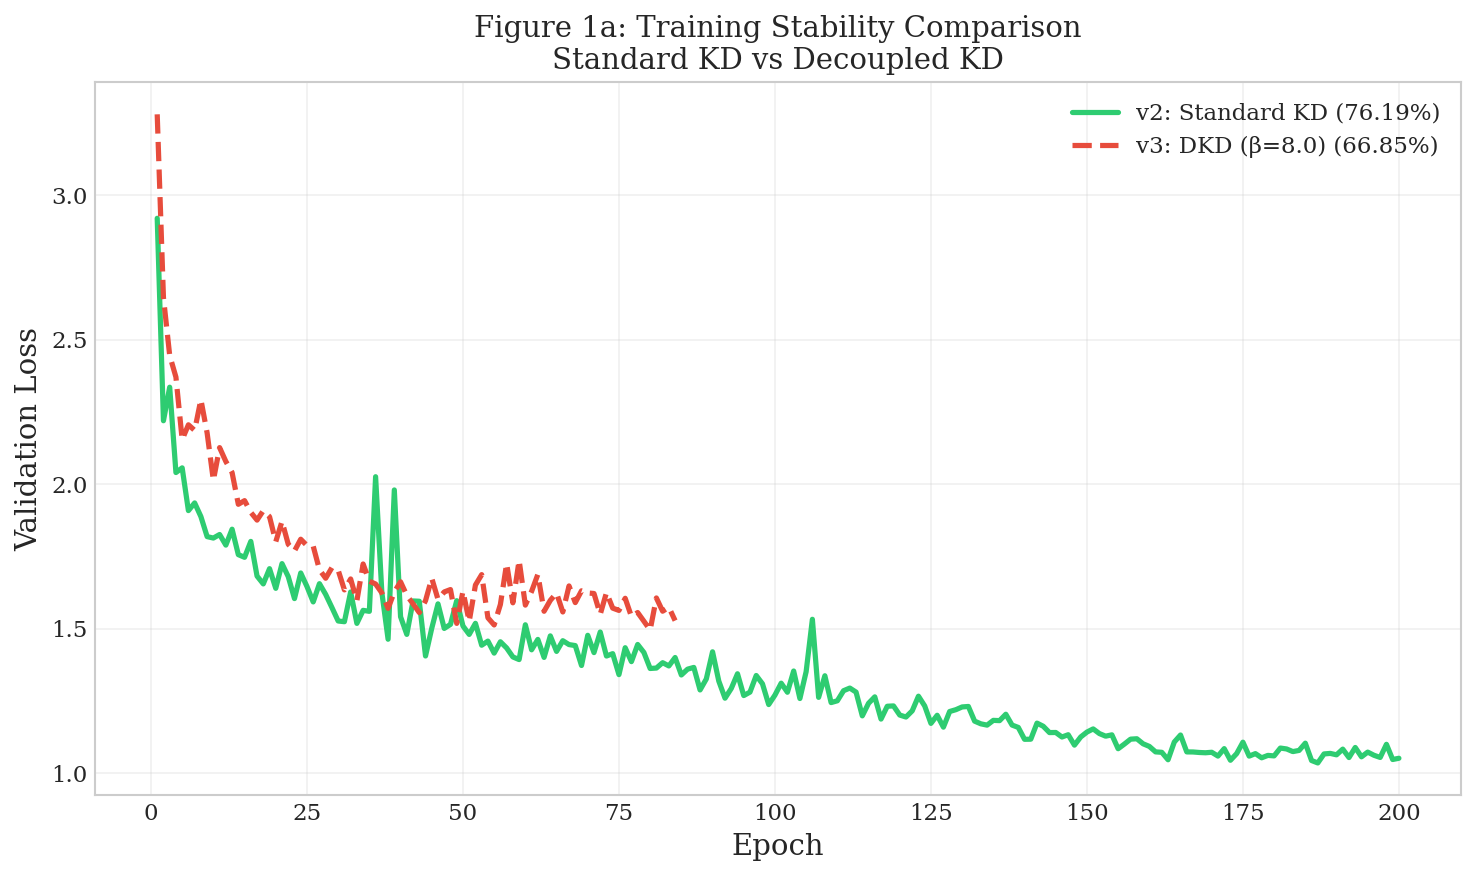

Saved: fig1a_loss_kd_vs_dkd.pdf


In [24]:
# Cell 4: Figure 1a - Standard KD vs DKD Loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v2 (Standard KD) vs v3 (DKD)
for exp_id in ['v2_enhanced', 'v3_dkd_beta8']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_loss = history['val_loss']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        linestyle = '-' if exp_id == 'v2_enhanced' else '--'
        ax.plot(epochs, val_loss, color=COLORS[exp_id], label=label, 
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Figure 1a: Training Stability Comparison\nStandard KD vs Decoupled KD')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1a_loss_kd_vs_dkd.pdf')
plt.savefig(FIGURES_DIR / 'fig1a_loss_kd_vs_dkd.png')
plt.show()
print(f"Saved: fig1a_loss_kd_vs_dkd.pdf")

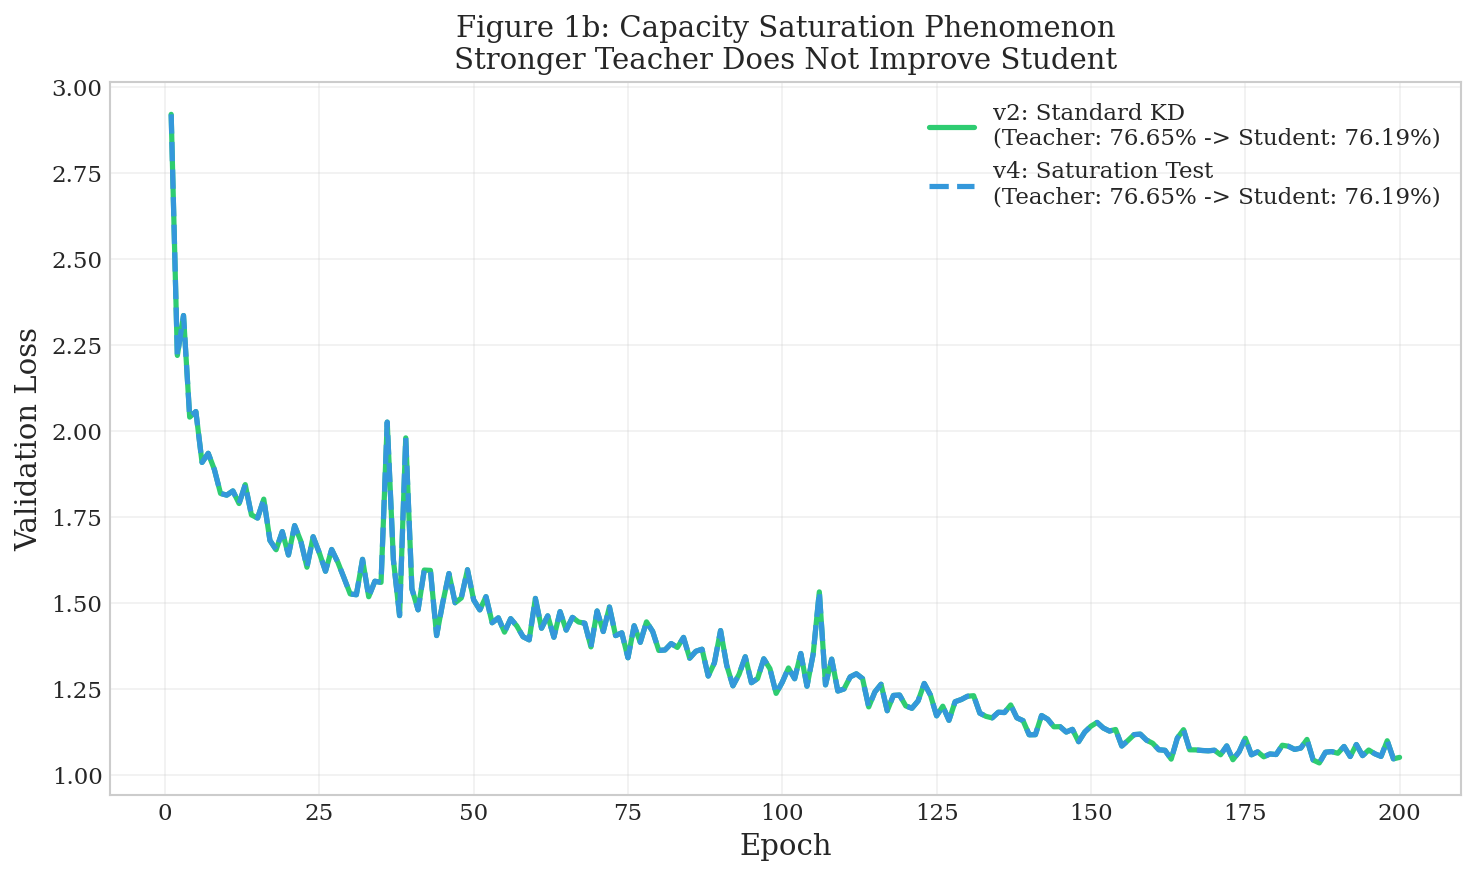

Saved: fig1b_loss_saturation.pdf


In [25]:
# Cell 5: Figure 1b - Saturation Phenomenon
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v2 vs v4 (Saturation)
for exp_id in ['v2_enhanced', 'v4_saturation']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_loss = history['val_loss']
        
        results = experiments[exp_id]['final']['results']
        teacher_acc = results.get('teacher_accuracy', 0)
        student_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]}\n(Teacher: {teacher_acc:.2f}% -> Student: {student_acc:.2f}%)"
        
        linestyle = '-' if exp_id == 'v2_enhanced' else '--'
        ax.plot(epochs, val_loss, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Loss')
ax.set_title('Figure 1b: Capacity Saturation Phenomenon\nStronger Teacher Does Not Improve Student')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1b_loss_saturation.pdf')
plt.savefig(FIGURES_DIR / 'fig1b_loss_saturation.png')
plt.show()
print(f"Saved: fig1b_loss_saturation.pdf")

## Figure 2: DKD Beta Comparison


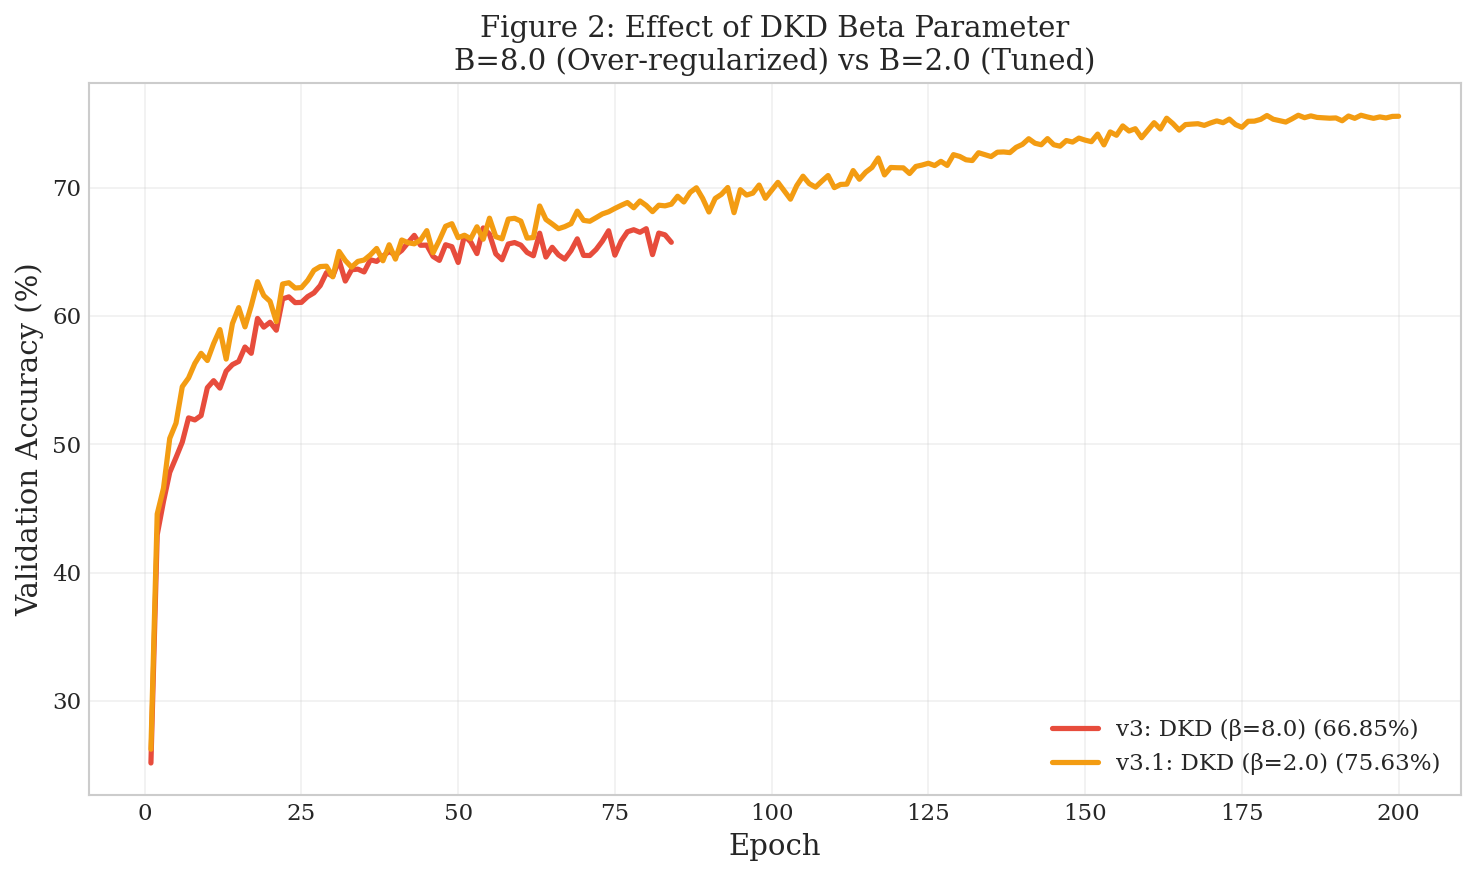

Saved: fig2_dkd_beta_comparison.pdf


In [26]:
# Cell 6: Figure 2 - DKD Beta Comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Plot v3 vs v3.1 (DKD beta comparison)
for exp_id in ['v3_dkd_beta8', 'v3_1_dkd_beta2']:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_acc = history['val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label, linewidth=2.5)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 2: Effect of DKD Beta Parameter\nB=8.0 (Over-regularized) vs B=2.0 (Tuned)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_dkd_beta_comparison.pdf')
plt.savefig(FIGURES_DIR / 'fig2_dkd_beta_comparison.png')
plt.show()
print(f"Saved: fig2_dkd_beta_comparison.pdf")

## Figure 3: All Experiments Accuracy


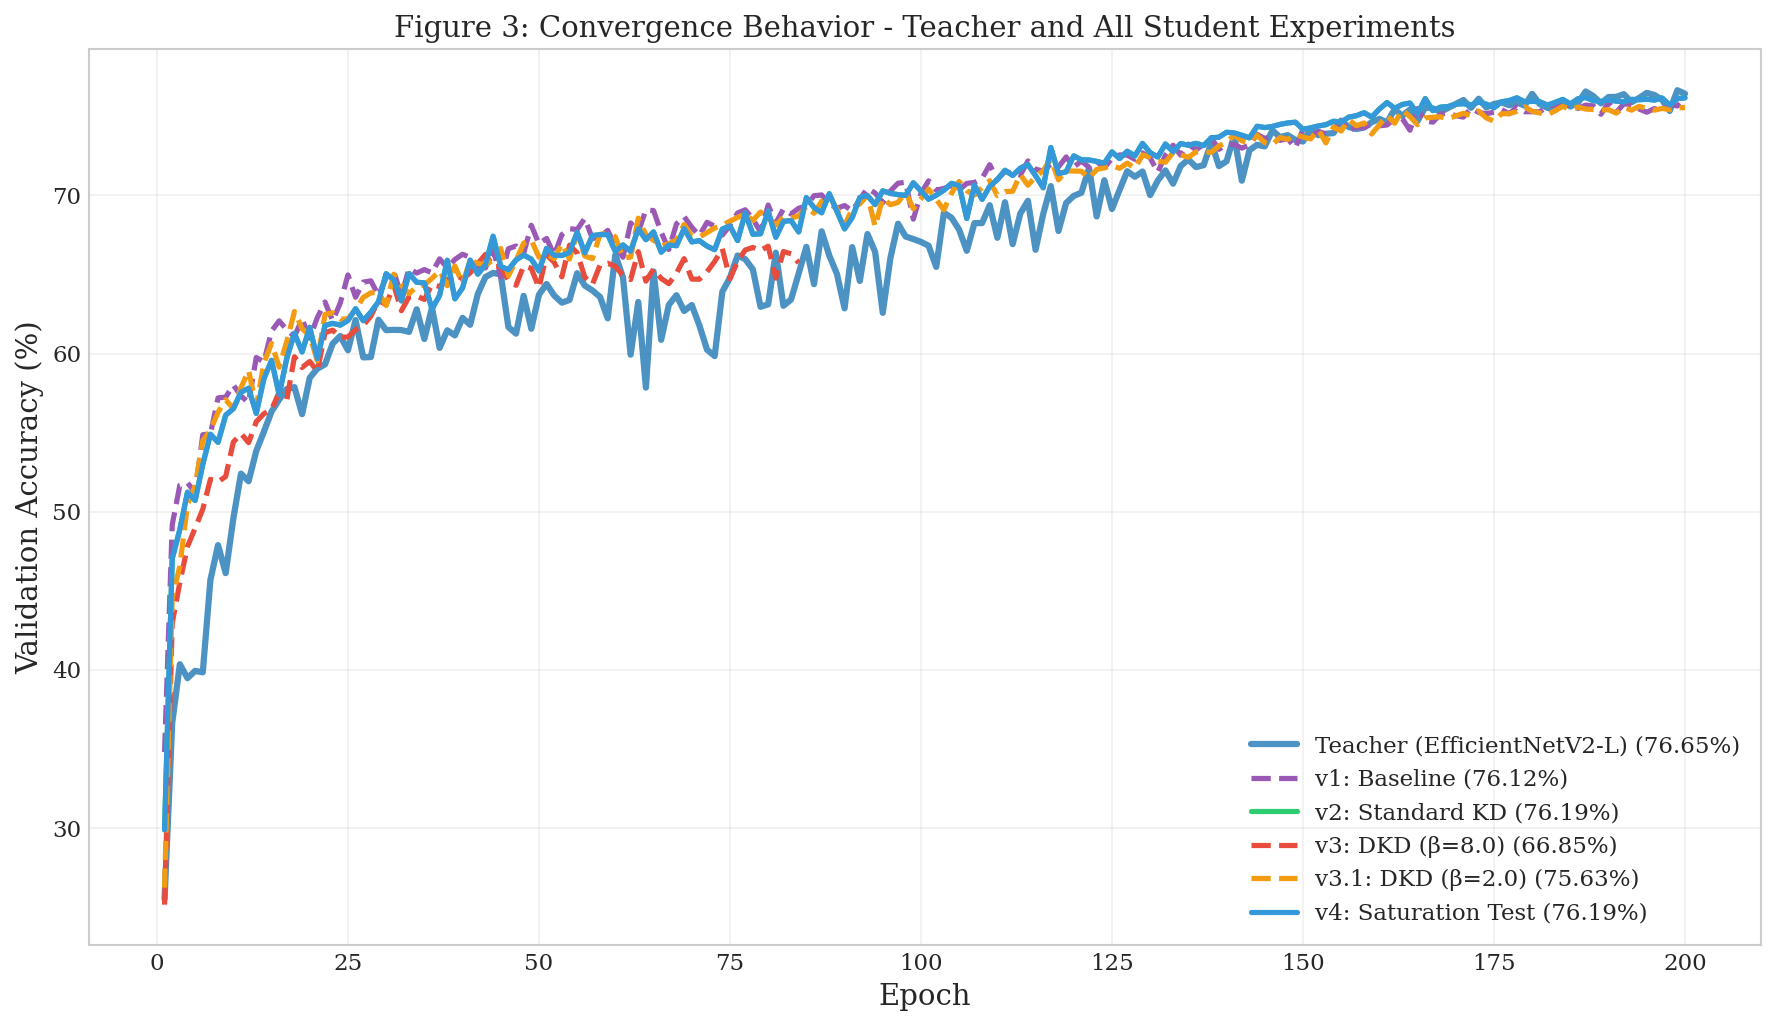

Saved: fig3_accuracy_all.pdf


In [27]:
# Cell 7: Figure 3 - All Experiments Accuracy Curves (Including Teacher)
fig, ax = plt.subplots(figsize=(12, 7))

# Plot Teacher first
if 'teacher' in experiments and 'history' in experiments['teacher']:
    history = experiments['teacher']['history']
    epochs = history['epoch']
    val_acc = history['val_accuracy']
    
    final_acc = get_accuracy(experiments['teacher'])
    label = f"{LABELS['teacher']} ({final_acc:.2f}%)"
    
    ax.plot(epochs, val_acc, color=COLORS['teacher'], label=label,
            linewidth=3, linestyle='-', alpha=0.8)

# Plot Students
for exp_id in student_experiments:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        epochs = history['epoch']
        val_acc = history['val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        linestyle = '-' if exp_id in ['v2_enhanced', 'v4_saturation'] else '--'
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 3: Convergence Behavior - Teacher and All Student Experiments')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_accuracy_all.pdf')
plt.savefig(FIGURES_DIR / 'fig3_accuracy_all.png')
plt.show()
print(f"Saved: fig3_accuracy_all.pdf")

## Figure 4: Teacher Retention Bar Chart


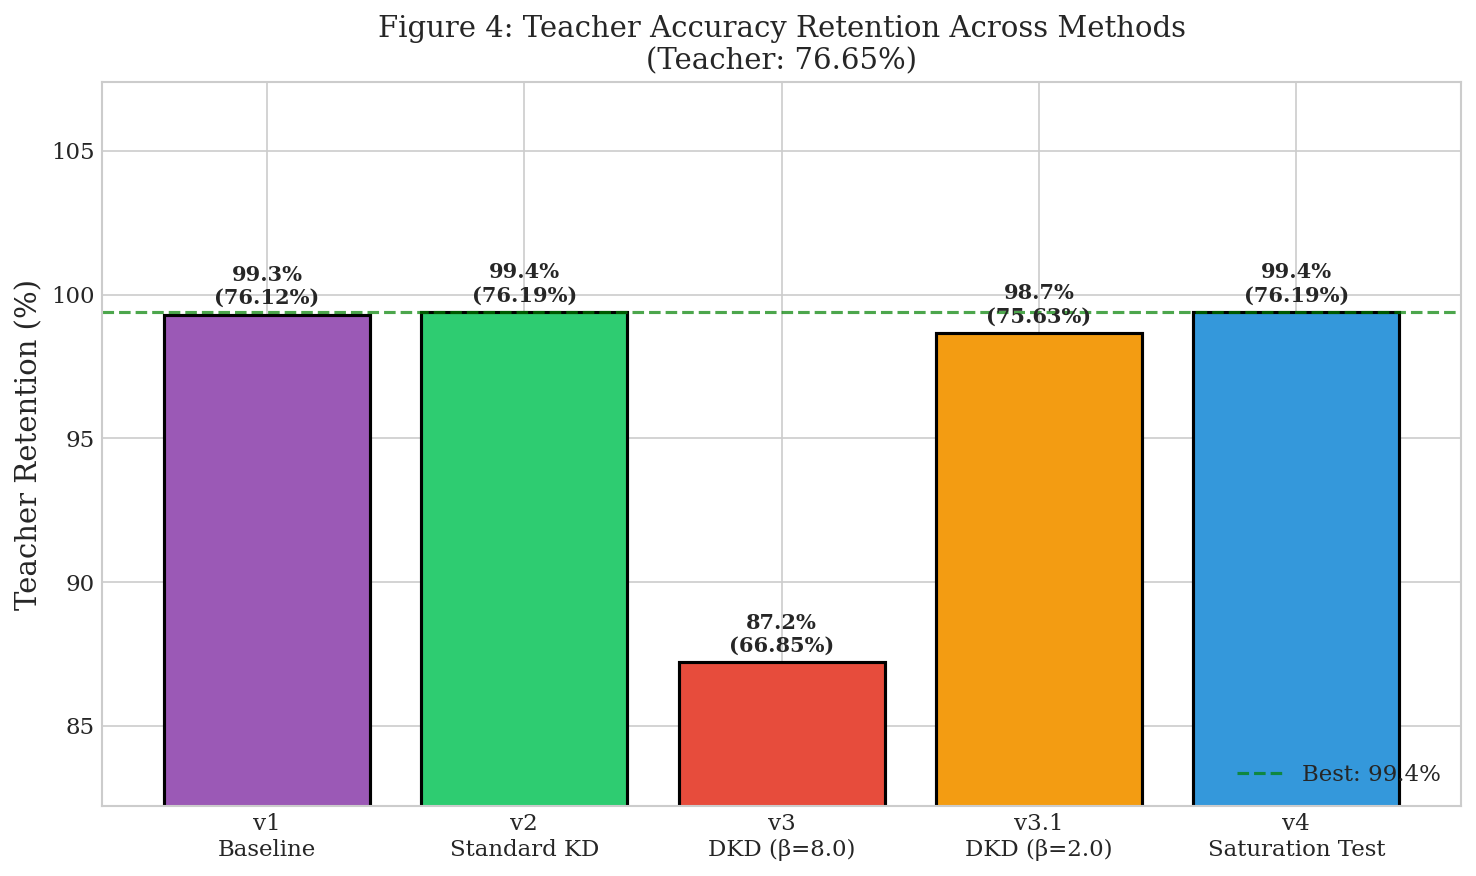

Saved: fig4_retention_bar.pdf


In [28]:
# Cell 8: Figure 4 - Retention Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Get teacher accuracy
teacher_acc = 0
if 'teacher' in experiments:
    teacher_acc = get_accuracy(experiments['teacher'])

# Prepare data
exp_names = []
retentions = []
student_accs = []
colors = []

for exp_id in student_experiments:
    if exp_id in experiments:
        student_acc = get_accuracy(experiments[exp_id])
        
        # Calculate retention (use teacher_accuracy from results if available)
        results = experiments[exp_id].get('final', {}).get('results', {})
        retention = results.get('retention_rate', 0)
        
        # If not available, calculate from teacher
        if retention == 0 and teacher_acc > 0:
            retention = (student_acc / teacher_acc) * 100
        
        exp_names.append(LABELS[exp_id].replace(': ', '\n'))
        retentions.append(retention)
        student_accs.append(student_acc)
        colors.append(COLORS[exp_id])

if retentions:
    # Create bar chart
    bars = ax.bar(exp_names, retentions, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, ret, acc in zip(bars, retentions, student_accs):
        height = bar.get_height()
        ax.annotate(f'{ret:.1f}%\n({acc:.2f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_ylabel('Teacher Retention (%)')
    ax.set_title(f'Figure 4: Teacher Accuracy Retention Across Methods\n(Teacher: {teacher_acc:.2f}%)')
    ax.set_ylim(min(retentions) - 5, max(retentions) + 8)
    
    # Add best line
    best_retention = max(retentions)
    ax.axhline(y=best_retention, color='green', linestyle='--', alpha=0.7, 
               linewidth=1.5, label=f'Best: {best_retention:.1f}%')
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'fig4_retention_bar.pdf')
    plt.savefig(FIGURES_DIR / 'fig4_retention_bar.png')
    plt.show()
    print(f"Saved: fig4_retention_bar.pdf")
else:
    print("No student experiments found to create retention chart")

## Figure 5: Zoomed-in Convergence Analysis


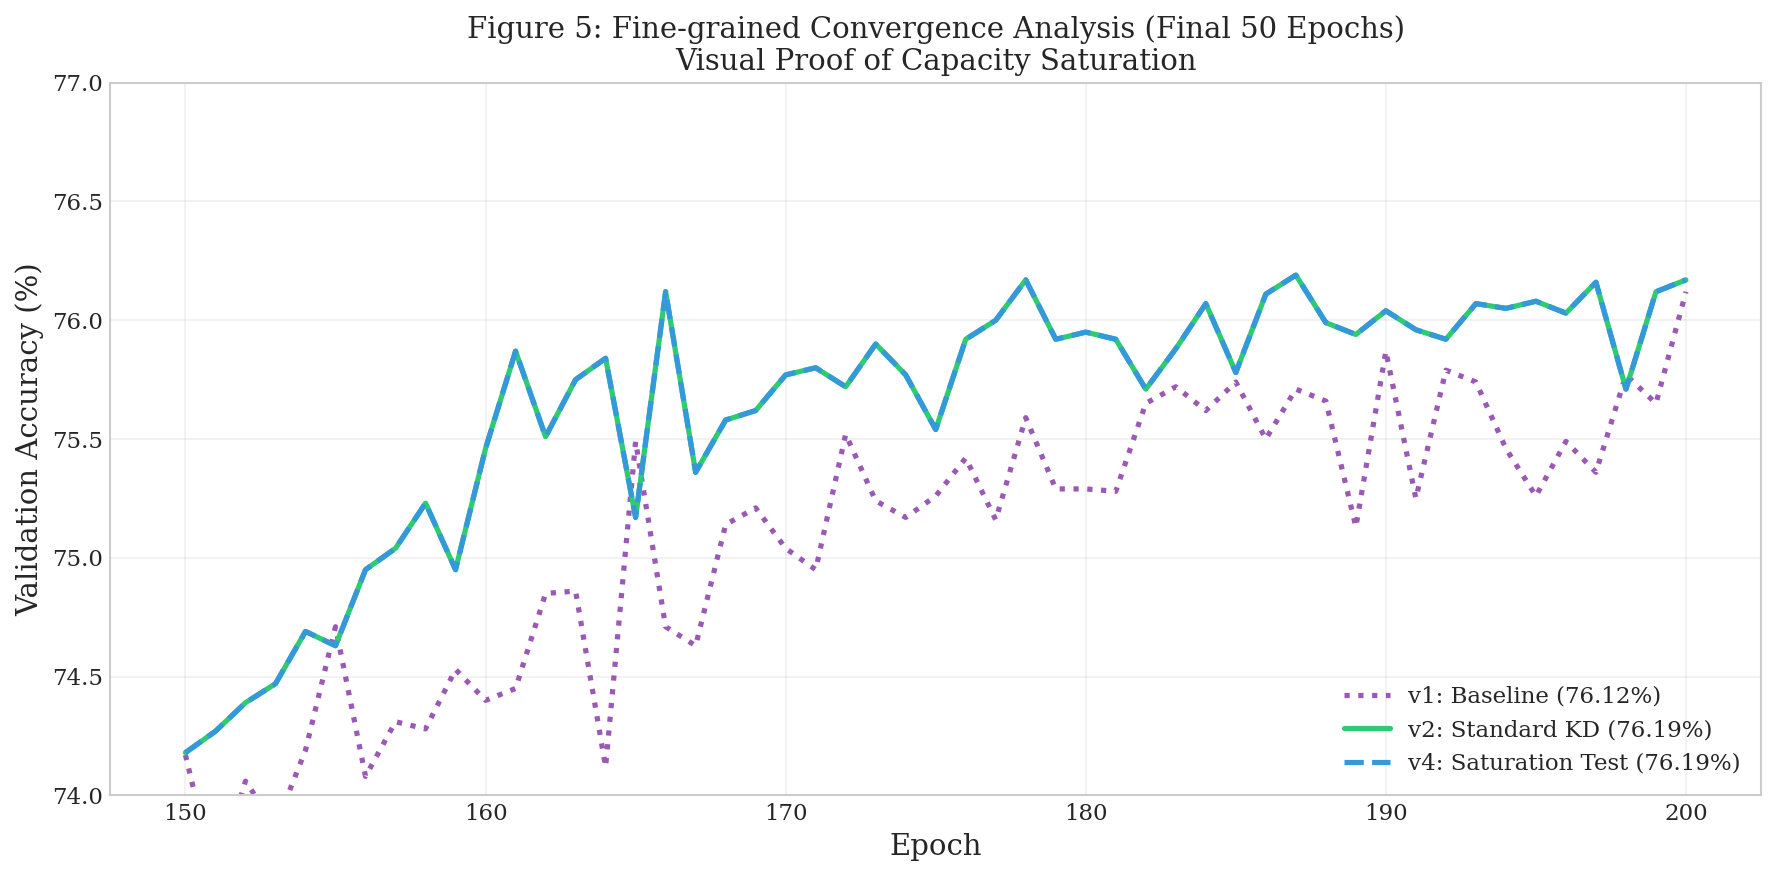

Saved: fig5_zoomed_saturation.pdf


In [29]:
# Cell 9: Figure 5 - Zoomed-in Convergence (Final 50 Epochs)
fig, ax = plt.subplots(figsize=(12, 6))

zoom_start_epoch = 150
experiments_to_plot = ['v1_baseline', 'v2_enhanced', 'v4_saturation']

for exp_id in experiments_to_plot:
    if exp_id in experiments and 'history' in experiments[exp_id]:
        history = experiments[exp_id]['history']
        
        # Filter for last 50 epochs
        mask = history['epoch'] >= zoom_start_epoch
        epochs = history.loc[mask, 'epoch']
        val_acc = history.loc[mask, 'val_accuracy']
        
        final_acc = get_accuracy(experiments[exp_id])
        label = f"{LABELS[exp_id]} ({final_acc:.2f}%)"
        
        # Make lines distinct
        linestyle = '-'
        if exp_id == 'v1_baseline': linestyle = ':'
        elif exp_id == 'v4_saturation': linestyle = '--'
        
        ax.plot(epochs, val_acc, color=COLORS[exp_id], label=label,
                linewidth=2.5, linestyle=linestyle)

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy (%)')
ax.set_title('Figure 5: Fine-grained Convergence Analysis (Final 50 Epochs)\nVisual Proof of Capacity Saturation')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
# Set y-axis limits to focus on the top performance range
ax.set_ylim(bottom=74.0, top=77.0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_zoomed_saturation.pdf')
plt.savefig(FIGURES_DIR / 'fig5_zoomed_saturation.png')
plt.show()
print(f"Saved: fig5_zoomed_saturation.pdf")

## Summary


In [30]:
# Cell 10: List Generated Figures
print("=" * 60)
print("GENERATED FIGURES")
print("=" * 60)

for f in sorted(FIGURES_DIR.glob("*.pdf")):
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name} ({size_kb:.1f} KB)")

print(f"\nTotal: {len(list(FIGURES_DIR.glob('*.pdf')))} PDF figures")
print(f"Location: {FIGURES_DIR}")

GENERATED FIGURES
  fig1a_loss_kd_vs_dkd.pdf (20.9 KB)
  fig1b_loss_saturation.pdf (20.5 KB)
  fig2_dkd_beta_comparison.pdf (21.1 KB)
  fig3_accuracy_all.pdf (27.0 KB)
  fig4_retention_bar.pdf (23.7 KB)
  fig5_zoomed_saturation.pdf (18.4 KB)

Total: 6 PDF figures
Location: d:\Projects\MasterProject\code_v2\figures
